In [21]:
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
from scipy.special import expit as sigmoid
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [22]:
models = [
    #"ConvNet_batch2048_weight1.0_secondpart_30k",
    "ConvNet_batch2048_secondpart_30k",
    #"ConvNet_batch2048_weight0_secondpart_30k",
    #"vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000",
    
    "phyloP",
    "phastCons",
]
model_renaming = {
    #"ConvNet_batch2048_secondpart_30k": "GPN",
    #"ConvNet_batch2048_secondpart_30k": "repeat-weight-0.1",
    "ConvNet_batch2048_secondpart_30k": "8 species",
    
    "ConvNet_batch2048_weight1.0_secondpart_30k": "repeat-weight-1",
    "ConvNet_batch2048_weight0_secondpart_30k": "repeat-weight-0",
    "vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000": "1 species",
}

d = Path(f"output/variants/all")
V = pd.read_parquet(d / "variants.parquet")

for m in models:
    model_path = d / f"{m}.parquet"
    model_name = model_renaming.get(m, m)
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V.consequence = V.consequence.str.replace("_variant", "")
V

,chrom,pos,ref,alt,AC,AF,consequence,8 species,phyloP,phastCons
0,1,266,G,A,82,0.040414,intergenic,-0.670362,0.813899,-0.000523
1,1,270,G,A,16,0.007886,intergenic,-0.406548,0.097275,-0.007196
2,1,276,T,G,16,0.007886,intergenic,-0.643284,0.493032,-0.000789
3,1,284,T,A,1,0.000493,intergenic,-0.779196,0.703100,-0.000292
4,1,286,T,A,1,0.000493,intergenic,-0.048531,1.644564,-0.000070
...,...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.773075,-0.285819
10697060,5,26975235,G,A,11,0.005421,intergenic,-1.822485,-0.267246,-0.259101
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.438794,-0.764734,-0.229109
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.521554,-0.862251,-0.094685


In [23]:
V.phyloP.isna().mean()

0.1415278061344683

In [3]:
fold_af = True
N_ACCESSIONS = 2029

if fold_af:
    fold_mask = V["AF"] > 0.5
    
    for m in models:
        if m in ["phyloP", "phastCons"]: continue
        V.loc[fold_mask, m] *= -1  # flip the sign of GPN scores
        
    V.loc[fold_mask, "AF"] = 1 - V.loc[fold_mask, "AF"]
    V.loc[fold_mask, "AC"] = N_ACCESSIONS - V.loc[fold_mask, "AC"]
V

,chrom,pos,ref,alt,AC,AF,consequence,8 species,1 species
0,1,266,G,A,82,0.040414,intergenic,-0.670362,-0.251338
1,1,270,G,A,16,0.007886,intergenic,-0.406548,-0.344978
2,1,276,T,G,16,0.007886,intergenic,-0.643284,0.059943
3,1,284,T,A,1,0.000493,intergenic,-0.779196,-0.729820
4,1,286,T,A,1,0.000493,intergenic,-0.048531,-0.465444
...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.808084
10697060,5,26975235,G,A,11,0.005421,intergenic,-1.822485,0.744265
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.438794,-0.797683
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.521554,-0.278273


In [4]:
if "phyloP" in models:
    V["phyloP-abs"] = -V["phyloP"].abs()
    models.append("phyloP-abs")

In [5]:
if not fold_af:
    V = V.query("AF < 0.5")
V

,chrom,pos,ref,alt,AC,AF,consequence,8 species,1 species
0,1,266,G,A,82,0.040414,intergenic,-0.670362,-0.251338
1,1,270,G,A,16,0.007886,intergenic,-0.406548,-0.344978
2,1,276,T,G,16,0.007886,intergenic,-0.643284,0.059943
3,1,284,T,A,1,0.000493,intergenic,-0.779196,-0.729820
4,1,286,T,A,1,0.000493,intergenic,-0.048531,-0.465444
...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.808084
10697060,5,26975235,G,A,11,0.005421,intergenic,-1.822485,0.744265
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.438794,-0.797683
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.521554,-0.278273


In [6]:
"""
plt.figure(figsize=(2,2))
sns.histplot(
    data=V,
    x="GPN",
    bins=50,
    stat="density",
)
plt.axvline(0, linestyle="--", color="black")
plt.xlabel("GPN score")
sns.despine();
#plt.savefig("output/plots/gpn_score_hist.svg", bbox_inches="tight")
"""

'\nplt.figure(figsize=(2,2))\nsns.histplot(\n    data=V,\n    x="GPN",\n    bins=50,\n    stat="density",\n)\nplt.axvline(0, linestyle="--", color="black")\nplt.xlabel("GPN score")\nsns.despine();\n#plt.savefig("output/plots/gpn_score_hist.svg", bbox_inches="tight")\n'

In [7]:
"""
bins = np.arange(-9.5, 5.5)

V["bin"] = pd.cut(V.GPN, bins)
V["bin_midpoint"] = V.bin.apply(lambda x: x.mid)
plt.figure(figsize=(2,2))
g = sns.lineplot(
    data=V,
    x="bin_midpoint",
    y="AF",
    errorbar=None,
)
plt.xlabel("GPN score")
plt.ylabel("Mean AF")
sns.despine();
#plt.savefig("output/plots/gpn_score_vs_af.svg", bbox_inches="tight")
"""

'\nbins = np.arange(-9.5, 5.5)\n\nV["bin"] = pd.cut(V.GPN, bins)\nV["bin_midpoint"] = V.bin.apply(lambda x: x.mid)\nplt.figure(figsize=(2,2))\ng = sns.lineplot(\n    data=V,\n    x="bin_midpoint",\n    y="AF",\n    errorbar=None,\n)\nplt.xlabel("GPN score")\nplt.ylabel("Mean AF")\nsns.despine();\n#plt.savefig("output/plots/gpn_score_vs_af.svg", bbox_inches="tight")\n'

In [8]:
"""
V["GPN score"] = V.bin
plt.figure(figsize=(4,4))
g = sns.ecdfplot(
    data=V,
    hue="GPN score",
    x="AF",
    palette="viridis",
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
#plt.savefig("output/plots/gpn_score_vs_af_cdf.pdf", bbox_inches="tight")
"""

'\nV["GPN score"] = V.bin\nplt.figure(figsize=(4,4))\ng = sns.ecdfplot(\n    data=V,\n    hue="GPN score",\n    x="AF",\n    palette="viridis",\n)\nsns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))\nsns.despine()\n#plt.savefig("output/plots/gpn_score_vs_af_cdf.pdf", bbox_inches="tight")\n'

In [9]:
consequences = [
    'all',
]
specific_consequences = V.consequence.value_counts()[:8].index.values.tolist()
consequences += specific_consequences
consequences

['all',
 'intergenic',
 'intron',
 'missense',
 'synonymous',
 'upstream_gene',
 'downstream_gene',
 '3_prime_UTR',
 '5_prime_UTR']

In [10]:
# conservation scores undefined in unaligned regions
V.dropna(inplace=True)
V

,chrom,pos,ref,alt,AC,AF,consequence,8 species,1 species
0,1,266,G,A,82,0.040414,intergenic,-0.670362,-0.251338
1,1,270,G,A,16,0.007886,intergenic,-0.406548,-0.344978
2,1,276,T,G,16,0.007886,intergenic,-0.643284,0.059943
3,1,284,T,A,1,0.000493,intergenic,-0.779196,-0.729820
4,1,286,T,A,1,0.000493,intergenic,-0.048531,-0.465444
...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.808084
10697060,5,26975235,G,A,11,0.005421,intergenic,-1.822485,0.744265
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.438794,-0.797683
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.521554,-0.278273


In [11]:
"""
from scipy.stats import pearsonr, spearmanr

for model in ["phyloP", "phastCons"]:
    print(model)
    print(pearsonr(V["GPN"], V[model]))
    print(spearmanr(V["GPN"], V[model]))
"""

'\nfrom scipy.stats import pearsonr, spearmanr\n\nfor model in ["phyloP", "phastCons"]:\n    print(model)\n    print(pearsonr(V["GPN"], V[model]))\n    print(spearmanr(V["GPN"], V[model]))\n'

In [12]:
V["Status"] = "Neither"

# default
V.loc[V.AC == 1, "Status"] = "Rare"
V.loc[V.AF >= 0.05, "Status"] = "Common"

# option 2
#V.loc[V.AC == 1, "Status"] = "Rare"
#V.loc[V.AF >= 0.01, "Status"] = "Common"

# option 3
#V.loc[V.AC <= 5, "Status"] = "Rare"
#V.loc[V.AF >= 0.05, "Status"] = "Common"

V = V[V.Status!="Neither"]
V.Status = V.Status.astype('category')
V.Status.value_counts()

/tmp/ipykernel_2541367/2391211216.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V.Status = V.Status.astype('category')


Status
Rare      3533830
Common    1760743
Name: count, dtype: int64

In [13]:
from math import sqrt

def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low" 
    #df.loc[df[model_name] > df[model_name].quantile(0.1), "ModelScoreTier"] = "High"
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]
    
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    group_counts = df.groupby(["Status", "ModelScoreTier"]).size()
    log_odds_se = sqrt(sum(1/group_counts)) # "All of statistics" eq. 15.7
    group_counts2 = group_counts.copy()
    #print(group_counts2); raise Exception("debug")
    group_counts = group_counts.loc[pd.MultiIndex.from_tuples(
        [['Common', 'High'],
         ['Common', 'Low'],
         ['Rare', 'High'],
         ['Rare', 'Low']]
    )].values.reshape((2,2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    log_odds_ratio = np.log(odds_ratio)
    ci_lower = np.exp(log_odds_ratio-2*log_odds_se)
    ci_upper = np.exp(log_odds_ratio+2*log_odds_se)
    # [ci_lower, ci_upper] is 95% CI
    if np.isinf(odds_ratio):
        print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper

In [14]:
def get_subtitle(consequence, n_rare, n_common):
    c = consequence.replace("_variant", "")
    return f"{c}\nn={n_rare} vs. {n_common}"

threshold_quantiles = [
    1e-3,
    1e-2,
    1e-1
]

rows = []
for c in consequences:
    if c == "all":
        df_c = V.copy()
    else:
        df_c = V[V.consequence==c]
    df_c = df_c.dropna(subset=models)
    for m in models:
        subtitle = get_subtitle(c, (df_c.Status=="Rare").sum(), (df_c.Status=="Common").sum())
        for tq in threshold_quantiles:
            #print(c, m, tq)
            OR, p_value, min_counts, cil, ciu = compute_odds_ratio(df_c[[m, "Status"]], tq, m)
            rows.append([m, c, tq, OR, p_value, min_counts, cil, ciu, subtitle])
results = pd.DataFrame(rows, columns=["Model", "Consequence", "Threshold quantile", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "subtitle"])
results

,Model,Consequence,Threshold quantile,Odds ratio,p_value,min_counts,cil,ciu,subtitle
0,8 species,all,0.001,4.503162,0.000000e+00,528,4.108379,4.935879,all\nn=3533830 vs. 1760743
1,8 species,all,0.010,2.900784,0.000000e+00,7817,2.830376,2.972944,all\nn=3533830 vs. 1760743
2,8 species,all,0.100,1.969620,0.000000e+00,112097,1.955884,1.983453,all\nn=3533830 vs. 1760743
3,1 species,all,0.001,2.467904,3.885394e-160,890,2.292963,2.656193,all\nn=3533830 vs. 1760743
4,1 species,all,0.010,2.475934,0.000000e+00,8925,2.418933,2.534278,all\nn=3533830 vs. 1760743
5,1 species,all,0.100,1.855827,0.000000e+00,117028,1.843068,1.868675,all\nn=3533830 vs. 1760743
6,8 species,intergenic,0.001,2.164813,4.990482e-58,446,1.950638,2.402503,intergenic\nn=1773478 vs. 803002
7,8 species,intergenic,0.010,2.050302,0.000000e+00,4684,1.984898,2.117860,intergenic\nn=1773478 vs. 803002
8,8 species,intergenic,0.100,1.777858,0.000000e+00,54475,1.760080,1.795816,intergenic\nn=1773478 vs. 803002
9,1 species,intergenic,0.001,2.268622,6.517532e-64,429,2.040864,2.521796,intergenic\nn=1773478 vs. 803002


In [15]:
limit_per_consequence = results.query("min_counts < 10").groupby("Consequence")["Threshold quantile"].max()
limit_per_consequence

Series([], Name: Threshold quantile, dtype: float64)

In [16]:
def above_limit(r):
    try:
         l = limit_per_consequence[r.Consequence]
    except:
        return True
    return r["Threshold quantile"] > l

results["above_limit"] = results.apply(above_limit, axis=1)

In [17]:
"""
g = sns.relplot(
    data=results[(results.p_value<=0.05) & (results.above_limit)],
    x="Threshold quantile",
    y="Odds ratio",
    hue="Model",
    hue_order=models,
    col="subtitle",
    height=3,
    kind="line",
    marker="o",
    col_wrap=3,
    facet_kws={'sharey': False, 'sharex': True},
)
for ax in g.axes: ax.axhline(1, ls='--', color="grey")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(xscale='log');
g.fig.subplots_adjust(top=0.75)
#plt.savefig("output/plots/rare_vs_common_line.pdf", bbox_inches='tight')
"""

'\ng = sns.relplot(\n    data=results[(results.p_value<=0.05) & (results.above_limit)],\n    x="Threshold quantile",\n    y="Odds ratio",\n    hue="Model",\n    hue_order=models,\n    col="subtitle",\n    height=3,\n    kind="line",\n    marker="o",\n    col_wrap=3,\n    facet_kws={\'sharey\': False, \'sharex\': True},\n)\nfor ax in g.axes: ax.axhline(1, ls=\'--\', color="grey")\ng.set_titles(col_template="{col_name}", row_template="{row_name}")\ng.set(xscale=\'log\');\ng.fig.subplots_adjust(top=0.75)\n#plt.savefig("output/plots/rare_vs_common_line.pdf", bbox_inches=\'tight\')\n'

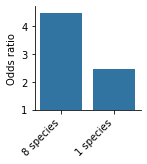

In [20]:
plt.figure(figsize=(1.9,1.9))
g = sns.barplot(
    data=results[(results.p_value<=0.05)&(results["Threshold quantile"]==1e-3)&(results.Consequence=="all")],
    y="Odds ratio",
    x="Model",
    color="C0",
);
g.set(ylim=(1))
sns.despine()
plt.xlabel("");
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right');
#plt.savefig("output/plots/rare_vs_common_bar.svg", bbox_inches='tight');
#plt.savefig("output/plots/rare_vs_common_bar_repeat_weight.svg", bbox_inches='tight');
#plt.savefig("output/plots/rare_vs_common_bar_1_vs_0.01.svg", bbox_inches='tight');
#plt.savefig("output/plots/rare_vs_common_bar_5_vs_0.05.svg", bbox_inches='tight');
#plt.savefig("output/plots/rare_vs_common_bar_n_species.svg", bbox_inches='tight');

In [19]:
#results[(results.p_value<=0.05) & (results["Threshold quantile"]==1e-3) & (results.Consequence=="all")]